1. Import Library

In [36]:
import numpy as np
import pandas as pd
import pickle
from IPython.display import display
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split

2. Baca dataset

In [37]:
df = pd.read_csv("2smart_irrigation_dataset.csv")

required_cols = ["Humidity", "Rainfall", "Sunlight", "Soil_Moisture", "Pump_Status"]
missing = [c for c in required_cols if c not in df.columns]
if missing:
    raise ValueError(f"Kolom wajib tidak ditemukan: {missing}")

mask_test = df["Pump_Status"].astype(str).str.strip().eq("?")
df_train = df.loc[~mask_test].copy()
df_test  = df.loc[ mask_test].copy()

print("Total data:", len(df))
print("Data latih (berlabel 0/1):", len(df_train))
print("Data uji (label '?'):", len(df_test))

display(df.head(5))

Total data: 2000
Data latih (berlabel 0/1): 1398
Data uji (label '?'): 602


,Humidity,Rainfall,Sunlight,Soil_Moisture,Pump_Status
0,86.170460,1,701.318754,58.399651,0
1,67.885326,0,873.933622,46.206334,0
2,38.232336,0,978.073943,78.325361,0
3,68.816262,0,831.091234,54.065483,0
4,91.780671,0,837.077373,36.844493,1


3. Split data: Data Latih dan Data Uji

In [38]:
feature_cols = ["Humidity", "Rainfall", "Sunlight", "Soil_Moisture"]
label_col = "Pump_Status"

# X dan y (yang berlabel saja)
X = df_train[feature_cols].copy()
y = df_train[label_col].astype(int)  # karena yang tersisa harus 0/1


X = X.apply(pd.to_numeric, errors="coerce")

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Distribusi label train:")
print(y_train.value_counts())
print("\nDistribusi label val:")
print(y_val.value_counts())


Distribusi label train:
Pump_Status
0    890
1    228
Name: count, dtype: int64

Distribusi label val:
Pump_Status
0    223
1     57
Name: count, dtype: int64


4. Training Model: Algoritma Random Forest

In [39]:
pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("rf", RandomForestClassifier(
        n_estimators=300,
        random_state=42,
        class_weight="balanced_subsample"
    ))
])

pipe.fit(X_train, y_train)
print("Training selesai.")


Training selesai.


5. Evaluasi

Akurasi: 99.29%

              precision    recall  f1-score   support

           0       0.99      1.00      1.00       223
           1       1.00      0.96      0.98        57

    accuracy                           0.99       280
   macro avg       1.00      0.98      0.99       280
weighted avg       0.99      0.99      0.99       280



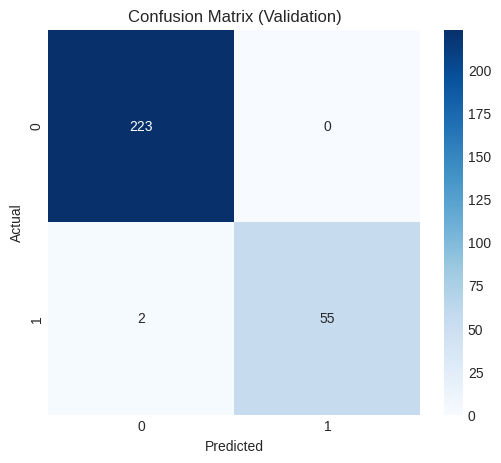

In [40]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_pred = pipe.predict(X_val)

print(f"Akurasi: {accuracy_score(y_val, y_pred)*100:.2f}%\n")
print(classification_report(y_val, y_pred))

cm = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix (Validation)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


6. Prediksi data uji

In [41]:
X_test_unlabeled = df_test[feature_cols].copy()
X_test_unlabeled = X_test_unlabeled.apply(pd.to_numeric, errors="coerce")


test_pred = pipe.predict(X_test_unlabeled)


result_df = df_test.copy()
result_df["Prediksi_Status_Pompa"] = test_pred

result_df = result_df.reset_index(drop=True)

display(result_df.head(20))


,Humidity,Rainfall,Sunlight,Soil_Moisture,Pump_Status,Prediksi_Status_Pompa
0,93.696784,0,241.664158,54.421357,?,0
1,84.868672,0,891.210319,18.620214,?,1
2,49.550545,0,501.674861,21.542821,?,1
3,93.602203,10,681.320848,34.353545,?,0
4,37.178715,5,487.636668,56.206449,?,0
5,34.314276,5,140.178813,50.301762,?,0
6,83.765447,0,251.983367,26.886009,?,1
7,61.565940,1,472.924468,87.809844,?,0
8,34.812839,0,391.968182,80.006007,?,0
9,39.849017,0,490.631079,81.159714,?,0


7. Simpan model

In [43]:
import joblib

bundle = {
    "model": pipe,
    "feature_order": ["Humidity", "Rainfall", "Sunlight", "Soil_Moisture"]
}

joblib.dump(bundle, "FiksModel_RandomForest_Evabenir.joblib")
print("Model tersimpan")

Model tersimpan
